In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [3]:
words = open('data/names.txt').read().splitlines()
words = list(w.lower() for w in words)
len(words)

21985

In [12]:
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
block_size = 3
vocab_size = len(stoi)

In [9]:
def build_dataset(words):
    X,Y = [],[]
    context = [0]*block_size
    for w in words:
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [11]:
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([125725, 3]) torch.Size([125725])
torch.Size([16100, 3]) torch.Size([16100])
torch.Size([15535, 3]) torch.Size([15535])


In [27]:
n_emb = 10
n_hidden = 200

C = torch.randn((vocab_size, n_emb))
W1 = torch.randn((n_emb*block_size, n_hidden)) * (5/3)/((n_emb * block_size)**0.5)
# b1 = torch.randn(n_hidden) * 0
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(vocab_size) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print('total params: ', sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

total params:  12730


In [29]:
batch_size = 32
max_steps = 200000
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]
    emb = C[Xb]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1 + b1
    
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain*(hpreact-bnmeani)/bnstdi+bnbias
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i<100000 else 0.001
    for p in parameters:
        p.data += -lr*p.grad
        
    if i%10000==0:
        print(f'{i}/{max_steps}, loss:{loss.item():.4f}')
    lossi.append(loss.log10().item())

0/200000, loss:3.3858
10000/200000, loss:2.7203
20000/200000, loss:2.6779
30000/200000, loss:2.4910
40000/200000, loss:2.3609
50000/200000, loss:2.4546
60000/200000, loss:2.6440
70000/200000, loss:2.2570
80000/200000, loss:2.5402
90000/200000, loss:2.3324
100000/200000, loss:2.0268
110000/200000, loss:2.1141
120000/200000, loss:2.0083
130000/200000, loss:2.4298
140000/200000, loss:2.1889
150000/200000, loss:2.0937
160000/200000, loss:1.8692
170000/200000, loss:2.0202
180000/200000, loss:2.2238
190000/200000, loss:1.9614


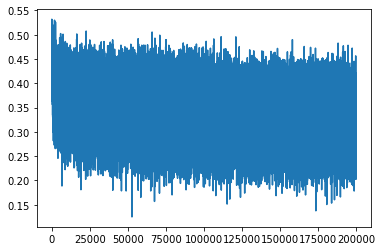

In [33]:
plt.plot(lossi);

In [38]:
with torch.no_grad():
    emb = C[Xtr]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat@W1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    

In [43]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    emb_cat = emb.view(emb.shape[0], -1)
    hpreact = emb_cat @ W1
    hpreact = bngain * (hpreact-bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.110860586166382
val 3.067075490951538


In [55]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out))/fan_in**0.5
        self.bias = None
        if bias:
            self.bias = torch.zeros(fan_out)
    
    def __call__(self, x):
        self.out = x@self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [bias])

In [60]:
class BatchNorm1D:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x-xmean)/torch.sqrt(xvar+self.eps)
        self.out = self.gamma * xhat + self.beta
        
        if self.training:
            with torch.no_grad():
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [64]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [65]:
n_emb = 10
n_hidden = 100

C = torch.randn((vocab_size, n_emb))
layers = [
    Linear(n_emb*block_size, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1D(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1D(vocab_size)
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print('total params:', sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

total params: 47360


In [121]:
max_steps = 2000000
batch_size = 32 
losses = []
ud = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb,Yb = Xtr[ix], Ytr[ix]
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for l in layers:
        x = l(x)
    loss = F.cross_entropy(x, Yb)
    
    for l in layers:
        l.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 150000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
        
    if i%10000==0:
        print(f"{i}/{max_steps}, loss: {loss.item(): .4f}")
    losses.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std()/p.data.std()).log10().item for p in parameters])
    
    if i>1000:
        break

0/2000000, loss:  2.2141


torch.Size([32, 100])
layer 2: Tanh,        m:-0.0059045422822237015, std:0.630691409111023 saturation:3.25%


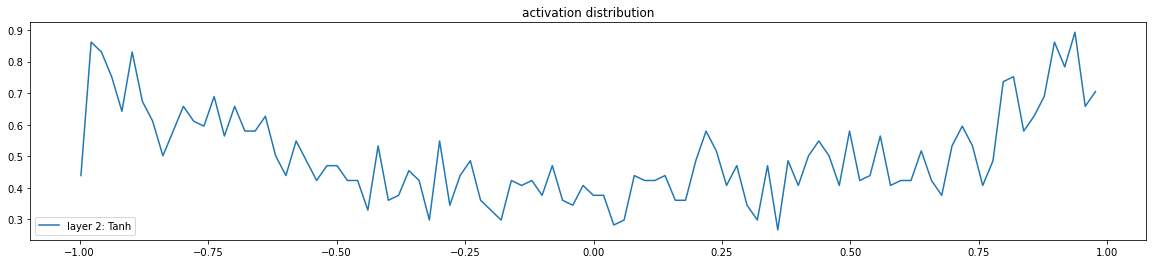

In [139]:
plt.figure(figsize=(20, 4));
legends =[]
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(t.shape)
        print(f"layer {i}: {layer.__class__.__name__},\
        m:{t.mean()}, std:{t.std()} saturation:{(t.abs() > 0.97).float().mean()*100}%")
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i}: {layer.__class__.__name__}")
        break
plt.legend(legends);     
plt.title('activation distribution');

In [120]:
hy,hx = torch.histogram(t, density=True)
hx.shape, hy.shape

(torch.Size([101]), torch.Size([100]))

In [124]:
hx

tensor([-0.9880, -0.9682, -0.9484, -0.9286, -0.9089, -0.8891, -0.8693, -0.8495,
        -0.8297, -0.8099, -0.7901, -0.7704, -0.7506, -0.7308, -0.7110, -0.6912,
        -0.6714, -0.6517, -0.6319, -0.6121, -0.5923, -0.5725, -0.5527, -0.5329,
        -0.5132, -0.4934, -0.4736, -0.4538, -0.4340, -0.4142, -0.3945, -0.3747,
        -0.3549, -0.3351, -0.3153, -0.2955, -0.2758, -0.2560, -0.2362, -0.2164,
        -0.1966, -0.1768, -0.1570, -0.1373, -0.1175, -0.0977, -0.0779, -0.0581,
        -0.0383, -0.0186,  0.0012,  0.0210,  0.0408,  0.0606,  0.0804,  0.1002,
         0.1199,  0.1397,  0.1595,  0.1793,  0.1991,  0.2189,  0.2386,  0.2584,
         0.2782,  0.2980,  0.3178,  0.3376,  0.3574,  0.3771,  0.3969,  0.4167,
         0.4365,  0.4563,  0.4761,  0.4958,  0.5156,  0.5354,  0.5552,  0.5750,
         0.5948,  0.6146,  0.6343,  0.6541,  0.6739,  0.6937,  0.7135,  0.7333,
         0.7530,  0.7728,  0.7926,  0.8124,  0.8322,  0.8520,  0.8718,  0.8915,
         0.9113,  0.9311,  0.9509,  0.97

In [127]:
hyp

tensor([0.5686, 0.7898, 0.6792, 1.2162, 0.9319, 1.0109, 0.9003, 0.9161, 0.9003,
        0.7266, 0.7898, 0.8687, 0.7740, 0.4423, 0.4739, 0.5212, 0.6002, 0.4739,
        0.4581, 0.4265, 0.5528, 0.6318, 0.5054, 0.3791, 0.4581, 0.3633, 0.4107,
        0.3949, 0.4739, 0.4423, 0.3475, 0.3159, 0.2843, 0.3475, 0.2685, 0.3475,
        0.3001, 0.2211, 0.3159, 0.2369, 0.3159, 0.3633, 0.3791, 0.2369, 0.3001,
        0.2685, 0.3317, 0.3633, 0.3633, 0.2843, 0.2685, 0.3317, 0.2843, 0.2527,
        0.1264, 0.3159, 0.3633, 0.2843, 0.2527, 0.3001, 0.3791, 0.2685, 0.4107,
        0.3633, 0.2843, 0.3949, 0.4423, 0.4107, 0.5212, 0.4896, 0.3317, 0.3159,
        0.5212, 0.3475, 0.2685, 0.3633, 0.4581, 0.3159, 0.3949, 0.5686, 0.4581,
        0.4897, 0.5370, 0.5844, 0.4897, 0.7266, 0.7898, 0.8213, 0.6634, 0.6002,
        1.0267, 1.0109, 0.9161, 0.9003, 1.1215, 0.8687, 0.8687, 0.8529, 0.6792,
        0.2369], grad_fn=<NotImplemented>)

In [146]:
hy,hx = torch.histogram(torch.tensor([1., 2, 3, 4, 1, 1]), density=True)

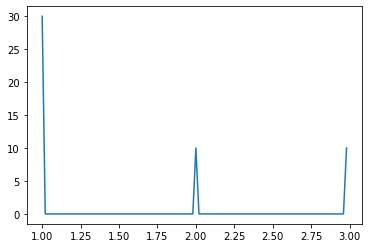

In [145]:
plt.plot(hx[:-1], hy);